In [41]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import pickle
import random
# from torchvision import transforms # no torchvision because we are not working with images but with points
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
data_file = open("./extended_prepared_dataset.pickle", "rb")
data = pickle.load(data_file)
print(len(data))
print(data[0][1])
# the symbols are one-hot encoded; alpha is the first and epsilon is the last symbol
# first 60 symbols are alpha; second 60 are beta etc.

300
[1. 0. 0. 0. 0.]


In [38]:
# Hyper-parameters 
input_size = 40 # 40 points from the normalized points
hidden_size = 128 
num_classes = 5 # 5 symbols
num_epochs = 2000
learning_rate = 0.001
random_seed = 69
test_split = 0.2
batch_size = 16

In [5]:
class CustomSymbolDataset(Dataset):
    def __init__(self, symbols, labels, transform=None, target_transform=None):
        """
            symbols - a list of tuples where the first 
            element is an array of normalized points and
            the second is the one-hot encoded vector of
            the respective symbol
        """
        self.symbols = symbols
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        symbol = self.symbols[idx]
        label = self.labels[idx]
        if self.transform:
            symbol = self.transform(symbol)
        if self.target_transform:
            label = self.target_transform(label)
        return symbol, label
    
class ToTensor(object):
    """Convert numpy array in sample to Tensors."""
    def __call__(self, sample):
        return torch.from_numpy(sample)
    
def get_coordinates(array: list):
    arr = array.copy()
    # arr.reverse()
    x = [point[0] for point in arr]
    y = [point[1] for point in arr]
    return x, y

In [6]:
symbols = [x[0] for x in data]
labels = [x[1] for x in data]
print(len(symbols), len(labels))

300 300


In [9]:
# Split the data into a train and validation set
X_train, X_val, y_train, y_val = train_test_split(
    symbols, 
    labels, 
    test_size=test_split,
    random_state=random_seed,
    shuffle=True)

print("Train ", len(X_train), len(y_train))
print("Val ", len(X_val), len(y_val))

# Define the train dataset and dataloader
train_dataset = CustomSymbolDataset(X_train, y_train, transform=ToTensor(), target_transform=ToTensor())
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)

# Define the validation dataset and dataloader
val_dataset = CustomSymbolDataset(X_val, y_val, transform=ToTensor(), target_transform=ToTensor())
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)

Train  240 240
Val  60 60


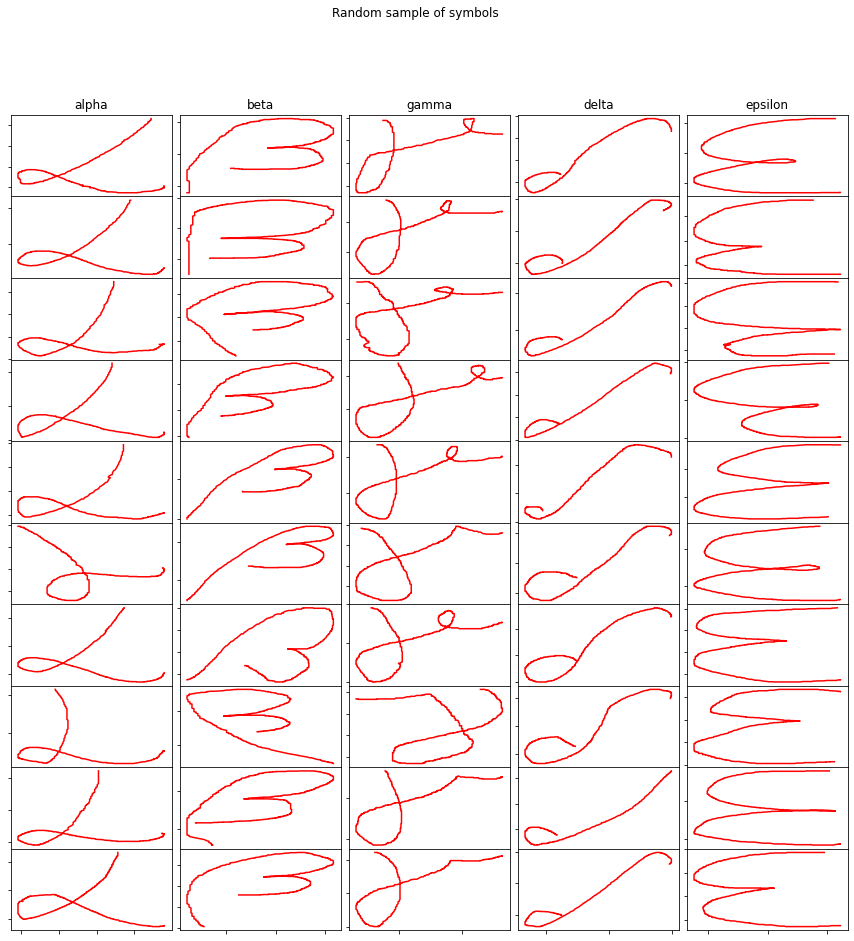

In [10]:
# Loading the raw data
image_per_symbol = 10
raw_data_file = open("raw_dataset.pickle", "rb")
raw_data = pickle.load(raw_data_file)
fig, ax = plt.subplots(image_per_symbol, 5, figsize=(15, 15))
fig.subplots_adjust(wspace=0.05, hspace=0)
fig.suptitle("Random sample of symbols")

# The axis have to be inverted because in the GUI the origin is in the top left corner. 
for i, symb in enumerate(['alpha', 'beta', 'gamma', 'delta', 'epsilon']):
    sample = random.sample(raw_data[i*30:(i+1)*30], image_per_symbol)
    ax[0, i].title.set_text(f"{symb}")
    for j, s in enumerate(sample):
        x, y = get_coordinates(s[0])
        ax[j, i].invert_yaxis()
        ax[j, i].plot(x, y, 'r', markersize=1)
        ax[j, i].set_yticklabels([])
        ax[j, i].set_xticklabels([])

In [45]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.3)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.3)
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.3)
        self.l4 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = x.to(torch.float32)
        out = self.l1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.l2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.l3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        out = self.dropout3(out)
        out = self.l4(out)
        
        # no activation and no softmax at the end
        return out

# Adding batch normalization layers can help to improve the stability and performance of the network by 
# reducing the internal covariate shift (the change in distribution of the layer's inputs due to the 
# change in parameters during training).

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define the scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

In [46]:
# Training loop
train_loss_history = list()
val_loss_history = list()

# Initialize the 'lowest' validation loss
lowest_val_loss = float('inf')

n_total_steps = len(train_dataloader)
for epoch in range(num_epochs):
    
    model.train()   # same as model.eval(), switch for some layers to train
    
    # Training batch
    for i, (symbols, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()

        # symbols = symbols.reshape(-1, 40).to(device)
        symbols = symbols.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(symbols)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
    if epoch+1 % 50:
        train_loss_history.append(loss.item())
    
    # Validation batch
    val_loss = 0.0
    model.eval()   # switch to calculate validation loss
    for val_symbols, val_labels in val_dataloader:
        with torch.no_grad():
            val_outputs = model(val_symbols)
            val_loss += criterion(val_outputs, val_labels).item()
    val_loss /= len(val_dataloader)
    if epoch+1 % 50:
        val_loss_history.append(val_loss)
    
    if (epoch+1) % 50 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}]\tTrain Loss: {loss.item():.6f}\tVal Loss: {val_loss:.6f}')
        
    # check if the current validation loss is lower than the lowest validation loss seen so far
    if val_loss < lowest_val_loss:
        lowest_val_loss = val_loss
        try:
            PATH = "best-symbol-recognizer.pt"
            # NOTE: This is actually how checkpoints are saved during training
            torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss,
                        }, PATH)
            # print(f"Model saved to {PATH}")
        except e as Exception:
            print(f"Model not saved. Exception.\n{e}")
            
    scheduler.step(metrics=val_loss)

Epoch [50/2000]	Train Loss: 0.135211	Val Loss: 0.388136
Epoch 00065: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00076: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00087: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00098: reducing learning rate of group 0 to 1.0000e-07.
Epoch [100/2000]	Train Loss: 0.061961	Val Loss: 0.412966
Epoch 00109: reducing learning rate of group 0 to 1.0000e-08.
Epoch [150/2000]	Train Loss: 0.215580	Val Loss: 0.411509
Epoch [200/2000]	Train Loss: 0.207546	Val Loss: 0.444334
Epoch [250/2000]	Train Loss: 0.150232	Val Loss: 0.429790
Epoch [300/2000]	Train Loss: 0.203295	Val Loss: 0.399819
Epoch [350/2000]	Train Loss: 0.092996	Val Loss: 0.425491
Epoch [400/2000]	Train Loss: 0.121008	Val Loss: 0.408698
Epoch [450/2000]	Train Loss: 0.155588	Val Loss: 0.426094
Epoch [500/2000]	Train Loss: 0.180293	Val Loss: 0.403388
Epoch [550/2000]	Train Loss: 0.129708	Val Loss: 0.421657
Epoch [600/2000]	Train Loss: 0.250362	Val Loss: 0.414428
Epoch [

Lowest loss is 0.32737480172716005.


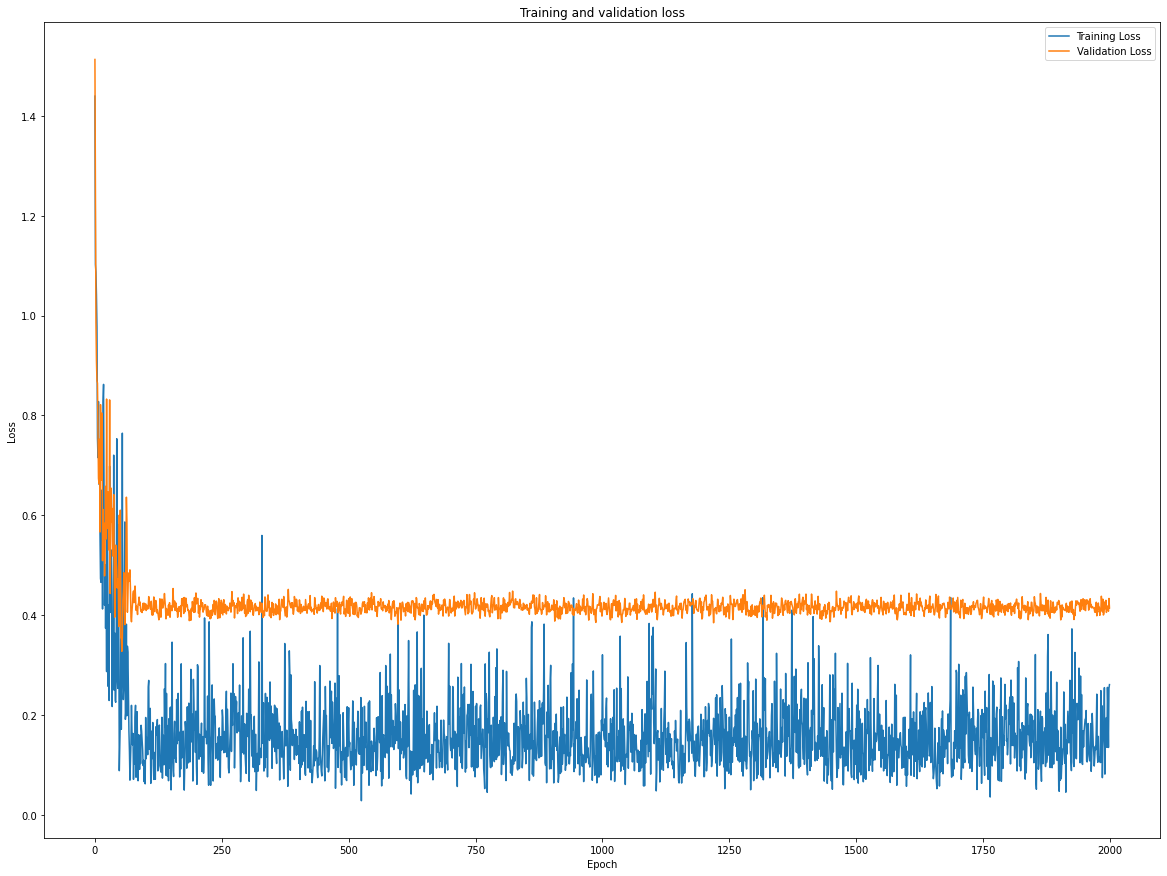

In [48]:
print(f"Lowest loss is {lowest_val_loss}.")

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)

# train_loss_history = train_loss_history[::15]
plt.plot(range(num_epochs), train_loss_history, label="Training Loss")
plt.plot(range(num_epochs), val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [60]:
# Loading model to check if the val losses are the same

# Loading the saved dictionary during training
checkpoint = torch.load(PATH)

model_ = NeuralNet(input_size, hidden_size, num_classes)
model_.load_state_dict(checkpoint['model_state_dict'])
# NOTE: load the optimizer state_dict, epoch and loss to continue training (checkpoint)

<All keys matched successfully>

In [66]:
# Test loop
model_.eval()
# A switch for some specific layers/parts of the model that behave
# differently during training and inference (evaluating) time. 
# For example, Dropouts Layers and BatchNorm Layers.
# Failing to do this will yield inconsistent inference results.
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        labels = torch.argmax(labels, dim=1)   # get the label from one-hot encod
        
        correct += (predicted == labels).sum().item()
    print('Validation accuracy: {}'.format(correct / total))

Test accuracy: 0.8833333333333333


In [209]:
# This dataset has 150 examples but the prepared has 300 because the dataset doubles
# as we inverse the array as we need to take into account symbols drawn the other way. 
raw_data_file = open("raw_dataset.pickle", "rb")
raw_data = pickle.load(raw_data_file)
print(len(raw_data))
print(raw_data[0][1])

# TODO: Train a couple of models; save the points as images and train a CNN model; try different architectures

# TODO: Saznaj kako si spremao ove točke jbg. Ima ih 40. Raspored x0, y0, x1, y1, x2, ...
# the symbols are one-hot encoded; alpha is the first and epsilon is the last symbol
# first 60 symbols are alpha; second 60 are beta etc.

# TODO: Visualize the wrongly inferred ones and put the wrong answer the model gave below them.
# TODO: uredi kod s labosa da gui funkcionira s novim modelom
# TODO: uredi preprocessing kod
# optional: uredi GUI
# TODO: odredi kako će se sve pokrećati (DOCKER i još neki izbori)
# TODO: uredi README
# TODO: tensorboard; odakle svi izvlače one lijepe grafove nakon treniranja i tesiranja pa stave na repo?
# TODO: konfuzijsku matricu napravi da vidiš gdje ti model najviše griješi!!!
# TODO: ko budes ima problema s inferencijom simbola, pazi da se modelu ne salju obrnute slike (horizontalno zrcaljene)
# TODO: add a test set and maybe expand the current dataset

# Loading the model
# TODO

150
alpha


In [ ]:
"""
Checkpoints are used during model training to save the current state of the model at a specific 
point in time, so that the training can be resumed from that point in case the training is 
interrupted or stopped. This allows you to save the progress of the training and avoid having to 
start over from scratch if something goes wrong.
"""